# `InferenceModel` API: Quick start guide

> **tldr:** This notebook introduces the InferenceModel API, a purely functional and immutable interface designed for running forecasts. It wraps a standard Model but provides methods (assimilate, advance, observe) that explicitly accept and return an immutable SimulationState object, making it fully compatible with JAX transformations. You will learn how to use this functional API, apply helper functions like `api.unroll_from_advance` to generate rollouts, and leverage the `InferenceRunner` to perform scalable, embarrassingly parallel inference tasks with Apache Beam.

The `InferenceModel` API is designed for users that are primarily interested in making forecasts and examining model outputs. It prioritizes "no surprise" behavior over flexibility.

Under the hood `InferenceModel` wraps a functional representation of a `Model` instance and provides purely functional interface to methods of said model. `InferenceModel` is immutable, and is registered as a jax pytree, making it compatible with JAX transformations.

Outline:
1. `InferenceModel` and `SimulationState`
2. Inference helper functions
3. Scalable inference using `apache_beam`



In [3]:
from functools import partial
import dataclasses
from typing import Callable

import coordax as cx
from flax import nnx
import jax
import jax.numpy as jnp
import jax_datetime as jdt
import numpy as np
import pandas as pd
import xarray


from neuralgcm.experimental.core import api
from neuralgcm.experimental.core import coordinates
from neuralgcm.experimental.core import observation_operators
from neuralgcm.experimental.core import nnx_compat
from neuralgcm.experimental.core import time_integrators
from neuralgcm.experimental.core import typing
from neuralgcm.experimental.core import module_utils
from neuralgcm.experimental.core import xarray_utils
from neuralgcm.experimental.inference import runner as inference_runner
from neuralgcm.experimental.inference import dynamic_inputs as inference_dynamic_inputs
from neuralgcm.experimental.toy_model_examples import lorenz96

import logging
import warnings
warnings.simplefilter('ignore')
logging.getLogger('jax._src.lib.xla_bridge').addFilter(lambda _: False)

## `InferenceModel` and `SimulationState`

**Key concepts:**
* `InferenceModel` is an immutable object providing functional interface to the underlying model methods
* `SimulationState` object holds all simulation variables and is passed as an explicit argument to `InferenceModel` methods
* If some simulation variables are missing, `InferenceModel` attempts to raise an informative error

### InferenceModel demo using Lorenz-96 system

As in the `Model` API notebook, we will use the Lorenz-96 dynamical system, this time loaded from `toy_model_examples` module.

Let's instantiate an inference model. We do so via `from_model_api` classmethod.

In [50]:
k = cx.LabeledAxis('k', np.arange(36))
j = cx.LabeledAxis('j', np.arange(8))

l96_model = lorenz96.Lorenz96WithTwoScales(k, j, forcing=nnx.Param(10.0))
l96_inference_model = api.InferenceModel.from_model_api(l96_model)

Under the hood, inference model contains:
* Model graph definition
* Model state (trainable parameters, constant arrays etc.)
* Dummy structure representing the expected simulation state structure
* Optional fiddle configuration required for serialization

In [51]:
print(l96_inference_model.__dict__.keys())

dict_keys(['model_graph_def', 'model_state', 'dummy_simulation_state', 'fiddle_config'])


In [52]:
l96_inference_model.model_state  # contains single trainable parameter `forcing`

State({
  'forcing': Param(
    value=10.0
  )
})

`InferenceModel` provides core methods similar to Model, but its methods are purely functional: they explicitly accept and return the required simulation state. For this reason initialization of random processes (via `rng` argument) and dynamic inputs a.k.a. forcings (via 'dynamic_inputs` argument) is done as a part of core methods.
*   **`assimilate`**: Takes `inputs`, `dynamic_inputs`, `rng`. Returns a `SimulationState`.
*   **`advance`**: Takes `simulation_state` and `dynamic_inputs`. Returns a `SimulationState`.
*   **`observe`**: Takes `simulation_state`, `query`, and `dynamic_inputs`. Returns a dictionary of dictionaries containing `cx.Field` objects.

Some of these methods have `None` defaults to simplify calls for models that do not require features like `dynamic_inputs` or `rng`.

`SimulationState` is a container that holds core simulation variables:

```python
@dataclasses.dataclass(frozen=True)
class SimulationState(Generic[State]):
  """Simulation state decomposed into prognostic, diagnostic and randomness.

  Attributes:
    prognostics: Prognostic state of the simulation.
    diagnostics: Optional diagnostic state of the simulation.
    randomness: Optional state of random processes in the simulation.
    extras: Optional additional simulation state variables.
  """

  prognostics: State
  diagnostics: State
  randomness: State
  extras: dict[str, State] = dataclasses.field(default_factory=dict)
```

Model developers can add additional types to be separated out of the model by updating `simulation_state_filters` property on their `Model` implementation.

In [65]:
# Preparing inputs for model initialization
kj = cx.compose_coordinates(k, j)
rng = np.random.RandomState(0)
x_init = abs(10 * np.sin(np.linspace(0, 13 * 2*np.pi, k.sizes['k'])))
x_init[0] += 0.01
t0 = jdt.Datetime.from_isoformat('2000-01-01')
inputs = {
    'slow': {'x': cx.wrap(x_init, k), 'time': cx.wrap(t0)},
    'fast': {'y': cx.wrap(rng.uniform(size=kj.shape, low=-0.5, high=0.5), kj)},
}
# assimilate expects at least a dummy timedelta dimension, we add it here.
t_del = coordinates.TimeDelta(np.zeros(1) * np.timedelta64(1, 'h'))
add_td = lambda f: f.broadcast_like(cx.compose_coordinates(t_del, f.coordinate))
inputs = jax.tree.map(add_td, inputs, is_leaf=cx.is_field)

# Assimilating inputs returns current simulation state.
sim_state = l96_inference_model.assimilate(inputs)

In [66]:
sim_state

SimulationState(prognostics=State({
  'time': Prognostic( # 2 (8 B)
    value=<Field dims=() shape=() axes={} >
  ),
  'x': Prognostic( # 36 (144 B)
    value=<Field dims=('k',) shape=(36,) axes={'k': LabeledAxis} >
  ),
  'y': Prognostic( # 288 (1.2 KB)
    value=<Field dims=('k', 'j') shape=(36, 8) axes={'j': LabeledAxis, 'k': LabeledAxis} >
  )
}), diagnostics=State({}), randomness=State({}), extras={'coupling': State({})})

`advance` computes a new simulation state given the previous without any side effects

In [69]:
sim_state.prognostics['time'].data

jax_datetime.Datetime(delta=jax_datetime.Timedelta(days=10957, seconds=0))

In [78]:
# Running advance on `InferenceModel`.
next_sim_state = sim_state
for _ in range(1300):  # burn in to get more interesting states.
  next_sim_state = l96_inference_model.advance(next_sim_state)

`observe` computes observation for a given `query`

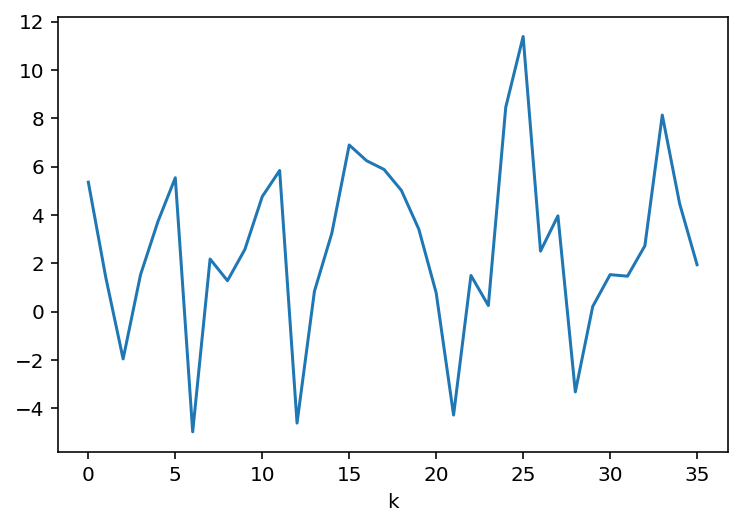

In [80]:
observation = l96_inference_model.observe(next_sim_state, {'slow': {'x': k}})
observation['slow']['x'].to_xarray().plot(x='k')

## Inference helper functions

**Key concepts:**
* `api.unroll_from_advance` and `api.forecast_steps` are helper functions that make fixed length rollouts
* `InferenceModel` is safer to use with forecast helpers as it does not result in any side effects

Let us make a prediction from the model using the state we obtained above using `api.unroll_from_advance`:

In [81]:
timedelta_between_saves = l96_inference_model.timestep * 5
final_state, trajectory = api.unroll_from_advance(
    l96_inference_model,
    initial_state=next_sim_state,
    timedelta=timedelta_between_saves,
    steps=100,
    query={'slow': {'x': k}}
)

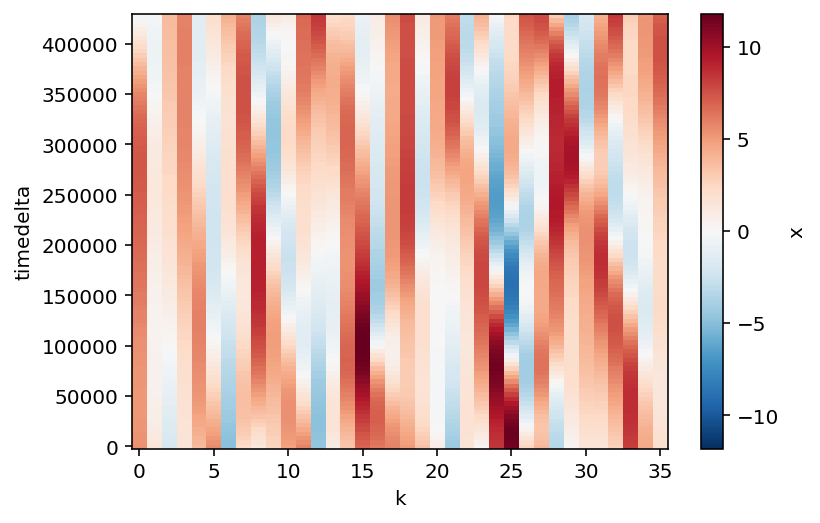

In [82]:
datasets = xarray_utils.nested_fields_to_xarray(trajectory)
# imshow isn't happy with timedelta64 coords, so we convert it to seconds here.
datasets['slow'].coords['timedelta'] = datasets['slow'].timedelta / np.timedelta64(1, 's')
datasets['slow'].x.plot.imshow(x='k', y='timedelta')
# here we have timedelta set in seconds (with single timestep being 864).

Another helper `api.forecast_steps` combines the initial assimilation step with the rollout:

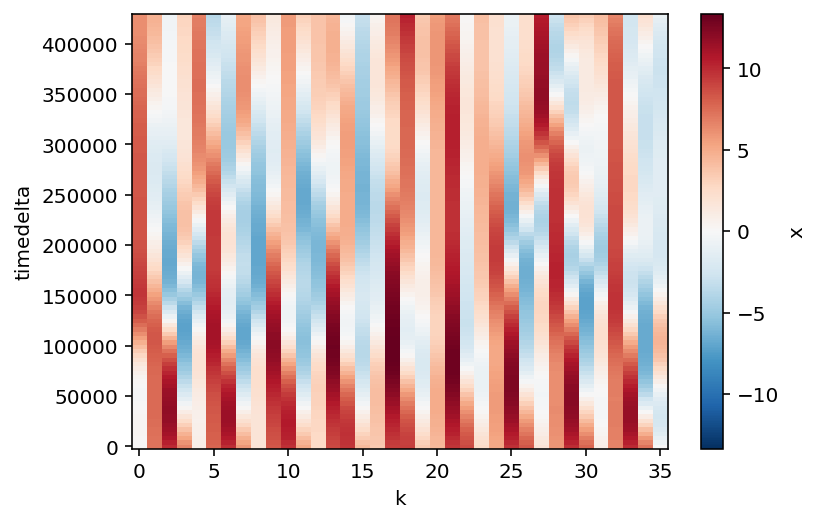

In [83]:
another_final_state, another_trajectory = api.forecast_steps(
    l96_inference_model,
    inputs=inputs,
    timedelta=timedelta_between_saves,
    steps=100,
    query={'slow': {'x': k}}
)
another_datasets = xarray_utils.nested_fields_to_xarray(another_trajectory)
another_datasets['slow'].coords['timedelta'] = another_datasets['slow'].timedelta / np.timedelta64(1, 's')
another_datasets['slow'].x.plot.imshow(x='k', y='timedelta')

We could repeat this simulation or any previous with the same `l96_inference_model` and get exactly same result.

In [84]:
newly_assimilated = l96_inference_model.assimilate(inputs)

np.testing.assert_allclose(
    newly_assimilated.prognostics['x'].data,
    sim_state.prognostics['x'].data,
)

## Scalable inference using InferenceRunner

**Key conepts:**
* `InferenceModel` can be used with `InferenceRunner` to run embarrassingly parallel inference tasks using Apache Beam.

First, let's generate a "ground truth" reference dataset. We will use this dataset as the source for our initial conditions.

In [98]:
_, trajectory = api.unroll_from_advance(
    l96_inference_model,
    initial_state=next_sim_state,
    timedelta=(l96_inference_model.timestep * 25),
    steps=4*100,  # 100 days.
    query={'slow': {'x': k, 'time': cx.Scalar()}, 'fast': {'y': kj, 'time': cx.Scalar()}},
)
ground_truth_data = xarray_utils.nested_fields_to_xarray(trajectory)
# Swap the 'timedelta' dimension with the 'time' coordinate and set 'time' as the index
ground_truth_data['slow'] = ground_truth_data['slow'].swap_dims({'timedelta': 'time'}).set_coords('time')
ground_truth_data['fast'] = ground_truth_data['fast'].swap_dims({'timedelta': 'time'}).set_coords('time')

Now let us setup inference parameters for `runner.InferenceRunner` and show how to run it directly from a python interpreter

In [109]:
output_path = './reforecasts.zarr'
output_query = {'slow': {'x': k}}
init_times = pd.date_range(
    pd.Timestamp('2000-01-14'),
    pd.Timestamp('2000-04-14'),
    freq=pd.Timedelta('1 day'),
    inclusive='left',
).values

zarr_chunks = {'lead_time': 1, 'init_time': 1}
runner = inference_runner.InferenceRunner(
    model=l96_inference_model,
    inputs=ground_truth_data,
    dynamic_inputs=inference_dynamic_inputs.EmptyDynamicInputs(),
    init_times=init_times,
    ensemble_size=1,
    zarr_chunks=zarr_chunks,
    output_path=output_path,
    output_query=output_query,
    output_freq=np.timedelta64(6, 'h'),
    output_duration=np.timedelta64(48, 'h'),
    write_duration=np.timedelta64(24, 'h'),
    unroll_duration=np.timedelta64(24, 'h'),
    checkpoint_duration=np.timedelta64(24, 'h'),
)
runner.setup()
for task_id in range(runner.task_count):
  runner.run(task_id)

For the inference tasks to be well defined `output_freq`, `output_duration` and
other parameters must be congruent. See the InferenceRunner docstring for details.

In [110]:
data_tree = xarray.open_datatree(output_path)

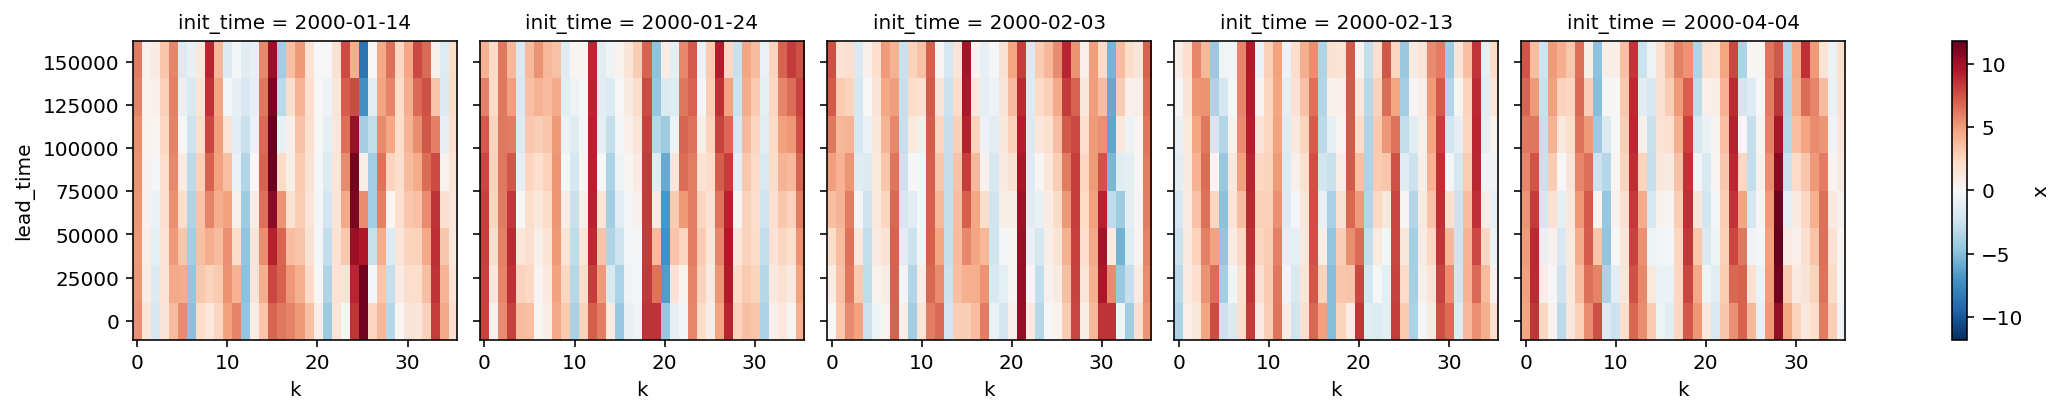

In [111]:
data_tree.coords['lead_time'] = data_tree.lead_time / np.timedelta64(1, 's')
data_tree['slow'].isel(init_time=[0, 10, 20, 30, -10], realization=0).x.plot.imshow(x='k', y='lead_time', col='init_time')

Now we repeat the process, but run it as a beam pipeline. Here it won't be faster since we are using `DirectRunner`, but this can scale to as many processes as the number of independent rollouts.

In [106]:
output_path = './reforecasts_beam.zarr'
output_query = {'slow': {'x': k}}
init_times = pd.date_range(
    pd.Timestamp('2000-01-14'),
    pd.Timestamp('2000-04-14'),
    freq=pd.Timedelta('1 day'),
    inclusive='left',
).values

zarr_chunks = {'lead_time': 1, 'init_time': 1}
runner = inference_runner.InferenceRunner(
    model=l96_inference_model,
    inputs=ground_truth_data,
    dynamic_inputs=inference_dynamic_inputs.EmptyDynamicInputs(),
    init_times=init_times,
    ensemble_size=1,
    zarr_chunks=zarr_chunks,
    output_path=output_path,
    output_query=output_query,
    output_freq=np.timedelta64(6, 'h'),
    output_duration=np.timedelta64(48, 'h'),
    write_duration=np.timedelta64(24, 'h'),
    unroll_duration=np.timedelta64(24, 'h'),
    checkpoint_duration=np.timedelta64(24, 'h'),
)
runner.setup()

In [ ]:
! pip install apache_beam

In [89]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

In [107]:
with beam.Pipeline(options=PipelineOptions(runner='DirectRunner')) as pipeline:
  _ = (
      pipeline
      | 'Create Tasks' >> beam.Create(range(runner.task_count))
      | 'Run Tasks' >> beam.Map(runner.run)
  )

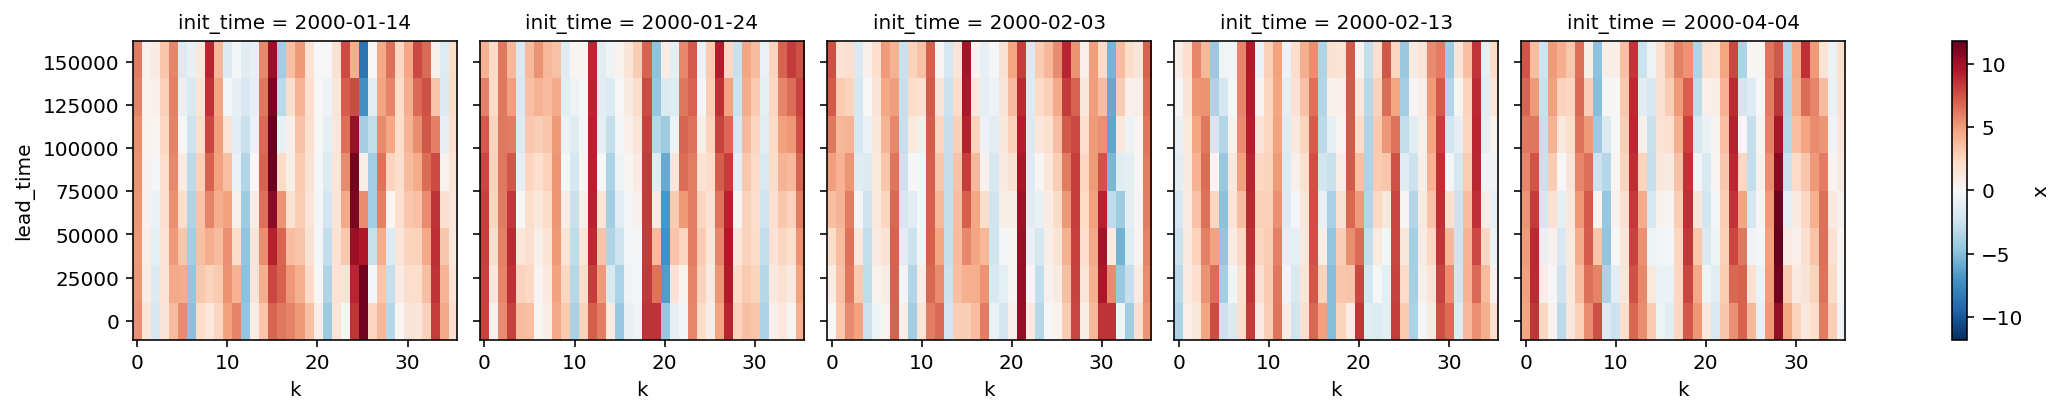

In [108]:
data_tree = xarray.open_datatree(output_path)
data_tree.coords['lead_time'] = data_tree.lead_time / np.timedelta64(1, 's')
data_tree['slow'].isel(init_time=[0, 10, 20, 30, -10], realization=0).x.plot.imshow(
    x='k', y='lead_time', col='init_time'
)

Similar approach can be used with Array jobs on traditional HPC setup.

In setup.py
```python
runner = InferenceRunner(...)
runner.setup()
```
In task.py
```python
runner = InferenceRunner(...)
runner.run(int(os.environ['SLURM_ARRAY_TASK_ID']))
```